## Model Stellar Spectra with 3 Stellar Parameters

In [1]:
%load_ext autoreload
%autoreload 2

### Import

In [2]:
import nbi
import torch
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

### Set path

In [3]:
data_path = '/stow/weilingfeng/data/apogee/'
save_path = f'{data_path}/nbi_3_params'

### New run or read existing model

In [4]:
new_run = True

### Read Data

In [5]:
# Read simulated spectra
with open(f'{data_path}/simulated_spectra_3_params.pkl', 'rb') as file:
    simulated_spectra = pickle.load(file)

wave = simulated_spectra['wave']
flux = simulated_spectra['flux']
params = np.array([simulated_spectra[_] for _ in ['teff', 'rv', 'vsini']]).T

### Define noise

In [6]:
def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])

    # let's say x_err is drawn from [0, 0.05]
    x_err = np.random.uniform() * 0.05
    x_noise = x + rand * x_err * x
    return x_noise, y

### Plot an example spectra

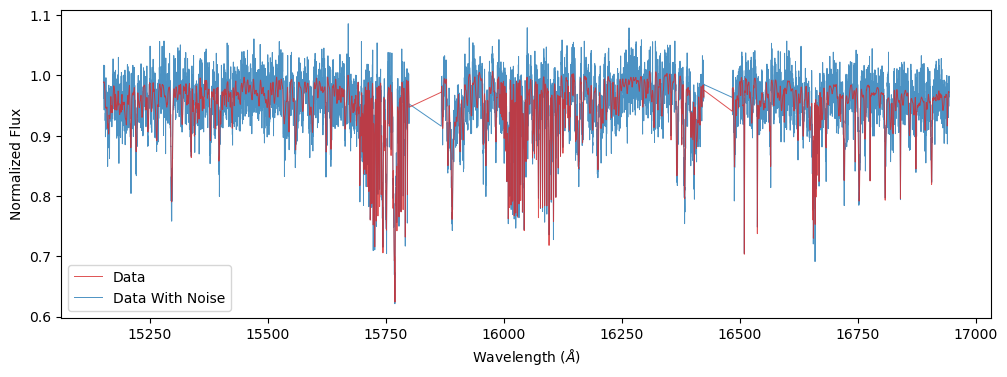

In [9]:
test_idx = 0

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(wave, flux[test_idx], lw=0.7, alpha=0.8, color='C3', label='Data', zorder=2)
ax.plot(wave, noise(flux[test_idx], params[test_idx])[0], lw=0.7, alpha=0.8, label='Data With Noise', zorder=1)
ax.legend()
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
plt.show()

### Set prior

In [10]:
prior = {
    'teff':     uniform(loc=2300, scale=7000-2300),  # U(2300, 7000) K
    'rv':       uniform(loc=-200, scale=200-(-200)), # U(-200, 200) km/s
    'vsini':    uniform(loc=0, scale=100)            # U(0, 100) km/s
}

labels = list(prior.keys())
priors = [prior[k] for k in labels]

### Setup nbi and train

In [11]:
if new_run:
    # clear cuda cache
    torch.cuda.empty_cache()
    
    # the NBI package provides the "ResNet-GRU" network as the default
    # featurizer network for sequential data
    featurizer = {
        'type': 'resnet-gru',
        'norm': 'weight_norm',
        'dim_in': 1,            # Number of channels for input data
        'dim_out': 256,         # Output feature vector dimension
        'dim_conv_max': 512,    # Maximum hidden dimension for CNN
        'depth': 8              # Number of 1D ResNet layers
    }

    flow = {
        'n_dims': len(labels),  # dimension of parameter space
        'flow_hidden': 256,
        'num_cond_inputs': 256,
        'num_blocks': 15,
        'n_mog': 4              # Number of Mixture of Gaussian as base density
    }

    # initialize NBI engine
    engine = nbi.NBI(
        flow=flow,
        featurizer=featurizer,
        priors=priors,
        labels=labels,
        device='cuda',
        path=save_path
    )

    engine.fit(
        x=flux,
        y=params,
        n_sims=flux.shape[0],
        n_rounds=1,
        n_epochs=100,
        batch_size=256,
        lr=0.0001,
        early_stop_patience=20,
        noise=noise  # this can also be an array if fixed noise
    )
    
    best_model = engine.best_params
    print(f'Best model saved in {best_model}')
    with open(f'{save_path}/best_model_path.txt', 'w') as file:
        file.write(best_model)


else:
    # Read existing model
    with open(f'{save_path}/best_model_path.txt', 'r') as file:
        best_model = file.read()
    
    engine = nbi.NBI(
        state_dict=best_model,
        priors=priors,
        labels=labels,
        device='cuda',
        path=save_path,
        njobs=16
    )


/home/weilingfeng/Software/miniconda3/envs/main/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Auto learning rate to min_lr = 1.28e-07
Use precomputed simulations for round  0

---------------------- Round: 0 ----------------------


  0%|          | 0/18000 [00:00<?, ?it/s]/home/weilingfeng/Software/miniconda3/envs/main/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
- Val, Loglike in nats: 7.681420:  90%|████████▉ | 1792/2000 [00:00<00:00, 2177.12it/s]


Best model saved in /stow/weilingfeng/data/apogee//nbi_3_params/0/97.pth


### Training & Validation Loss

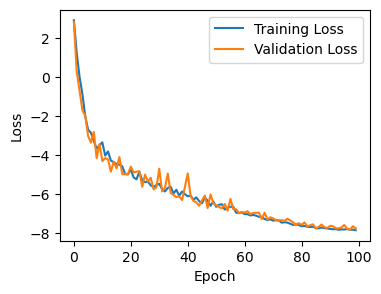

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(engine.train_losses[0], label='Training Loss')
ax.plot(engine.val_losses[0], label='Validation Loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

### Predict

/home/weilingfeng/Software/miniconda3/envs/main/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


surrogate posterior


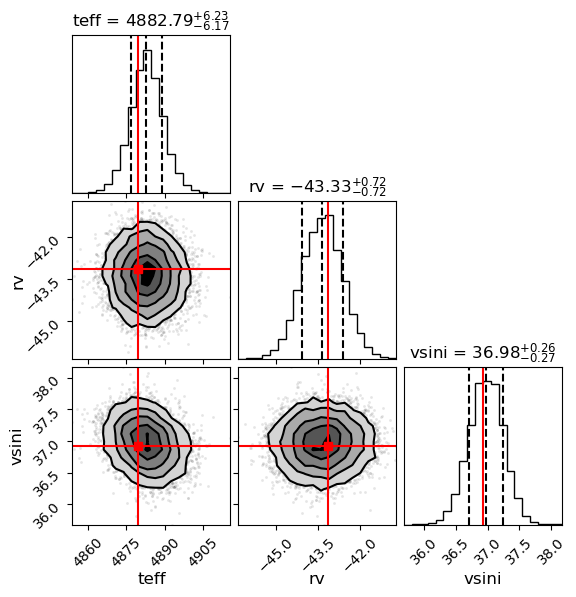

In [13]:
np.random.seed(0)

# draw random parameter from prior
dim = len(wave)

y_pred = engine.predict(
    flux[0], 
    y_true=params[0], 
    n_samples=12800, 
    corner=True, 
    corner_reweight=True, 
    seed=0
)

### Optional: simulator

Requires the installation of [`smart`](https://github.com/chihchunhsu/smart)

surrogate posterior


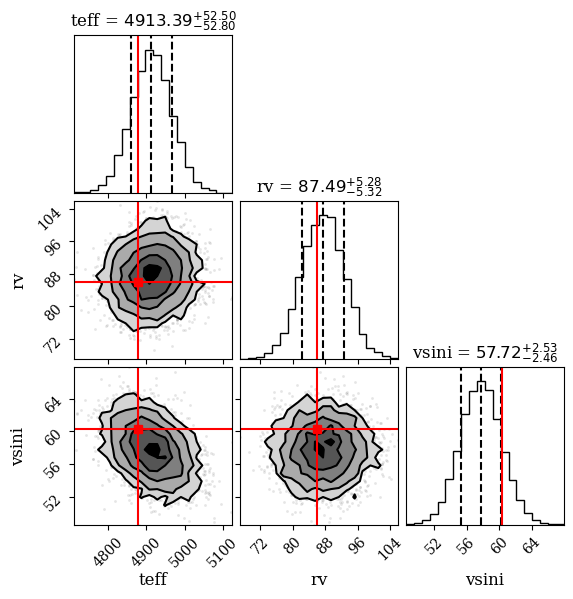

Generating simulations


320it [01:05,  4.86it/s]


Effective Sample Size = 159.9
Sampling efficiency = 3.1%


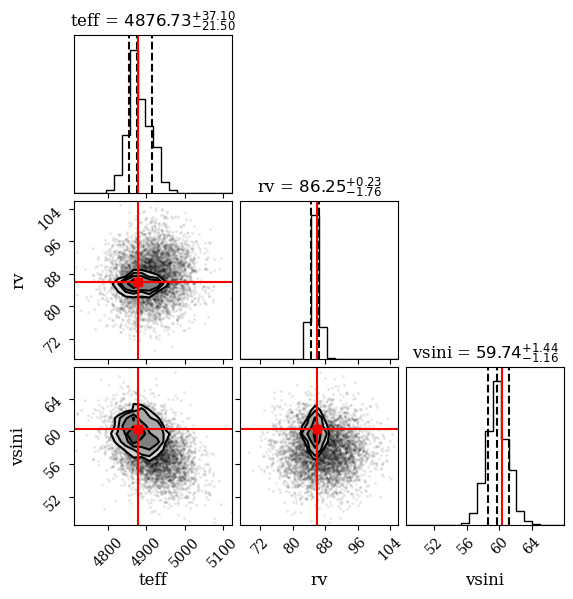

In [14]:
import smart
from matplotlib.lines import Line2D

# simulator
logg = simulated_spectra['logg']
metal = simulated_spectra['metal']
instrument = 'apogee'
order = 'all'
modelset = 'phoenix-aces-agss-cond-2011'
lsf  = simulated_spectra['lsf']
xlsf = simulated_spectra['xlsf']

def simulate_spectra(params):
    teff, rv, vsini = params
    model = smart.makeModel(teff=teff, rv=rv, vsini=vsini, logg=logg, metal=metal, instrument=instrument, order=order, modelset=modelset, lsf=lsf, xlsf=xlsf)
    model.flux = np.array(smart.integralResample(xh=model.wave, yh=model.flux, xl=wave))
    return model.flux


y_true = [var.rvs(1)[0] for var in priors]
x_err = 0.05
x_obs = simulate_spectra(y_true) + np.random.normal(size=len(wave)) * x_err

dim = len(wave)
engine.simulator = simulate_spectra
engine.n_jobs = 16
y_pred, weights = engine.predict(x_obs, x_err=np.zeros_like(x_obs)+0.05, y_true=y_true, n_samples=5120, corner=True, corner_reweight=True, seed=0)
plt.show()

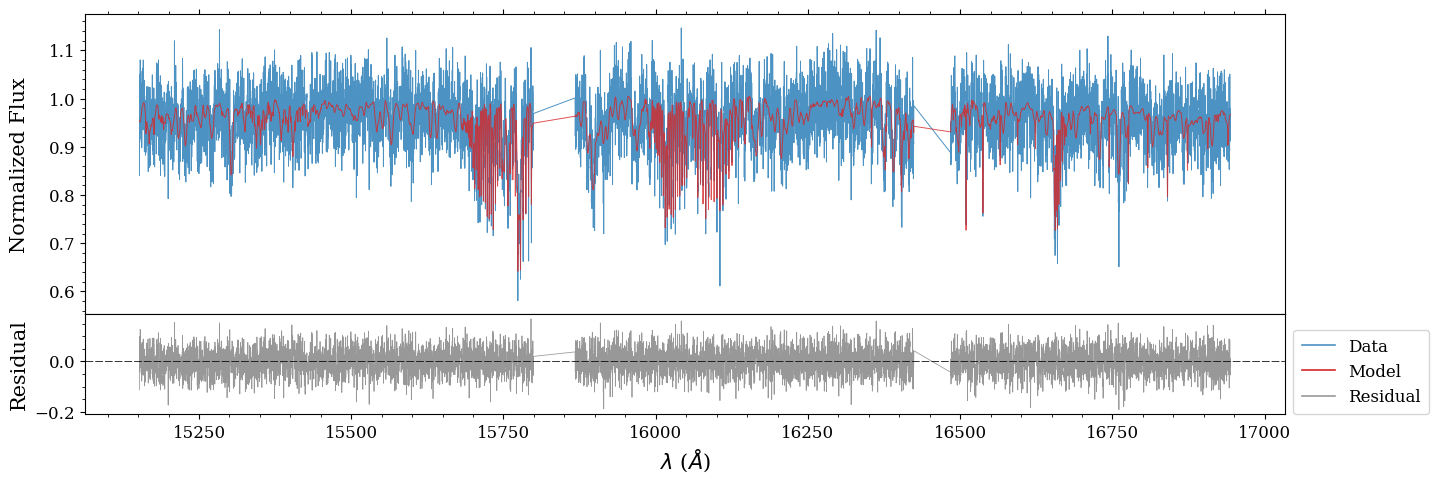

In [15]:
y_pred_med = np.median(y_pred, axis=0)


def plot_spectrum(wave, obs_spec, model_spec, lw=0.7, alpha=0.8, save_path=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax1.plot(wave, obs_spec, color='C0', alpha=alpha, lw=lw)
    ax1.plot(wave, model_spec, color='C3', alpha=alpha, lw=lw)
    ax2.plot(wave, obs_spec - model_spec, color='C7', alpha=alpha, lw=lw*0.8)

    ax1.minorticks_on()
    ax1.xaxis.tick_top()
    ax1.tick_params(axis='both', labelsize=12, labeltop=False)  # don't put tick labels at the top
    ax1.set_ylabel('Normalized Flux', fontsize=15)
    h1, l1 = ax1.get_legend_handles_labels()

    ax2.axhline(y=0, color='k', linestyle='--', dashes=(8, 2), alpha=alpha, lw=lw)
    ax2.minorticks_on()
    ax2.tick_params(axis='both', labelsize=12)
    ax2.set_xlabel(r'$\lambda$ ($\AA$)', fontsize=15)
    ax2.set_ylabel('Residual', fontsize=15)
    h2, l2 = ax2.get_legend_handles_labels()

    legend_elements = [
        Line2D([], [], color='C0', alpha=alpha, lw=1.2, label='Data'),
        Line2D([], [], color='C3', lw=1.2, label='Model'),
        Line2D([], [], color='C7', alpha=alpha, lw=1.2, label='Residual')
    ]

    ax2.legend(handles=legend_elements, frameon=True, loc='lower left', bbox_to_anchor=(1, -0.08), fontsize=12, borderpad=0.5)
    fig.align_ylabels((ax1, ax2))
    # ax1.set_title(f'APOGEE {apogee_id}, Teff={teff:.2f}±{e_teff:.2}, RV={rv:.2f}±{e_rv:.2f}, vsini={vsini:.2f}')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


plot_spectrum(wave, x_obs, simulate_spectra(y_pred_med), save_path='/home/weilingfeng/ML/Group7-Project/figure/Model Spectrum.pdf')